In [1]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

# this makes sure cached files are readily available (for calling e.g. `gather_data_cached`)
!apt-get install git-lfs
!git lfs install

# cloning repo
branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git

# moving into project dir
%cd bsc-thesis/src
%ls

/content
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Git LFS initialized.
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 974, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 974 (delta 76), reused 60 (delta 42), pack-reused 860 (from 2)
Receiving objects: 100% (974/974), 28.35 MiB | 17.76 MiB/s, done.
Resolving deltas: 100% (560/560), done.
Filtering content: 100% (32/32), 1.75 GiB | 61.75 MiB/s, done.
/content/bsc-thesis/src
backtesting/  data/      main.ipynb  models/         utils/
config/       external/  main.py     preprocessing/


In [2]:
!pip install ta
!pip install pykalman
!pip install PyWavelets
!pip install curl-cffi

## specific packages for time moe
# need a different version of accelerate because of bug "ImportError: cannot import name 'clear_device_cache' from 'accelerate.utils.memory'"
INSTALL_FOR_TIME_MOE = False
if INSTALL_FOR_TIME_MOE:
  !pip install numpy==1.26.3 # necessary for bug fix
  !pip install peft==0.10.0
  !pip install -U accelerate==0.32.0 # standard google colab version is 1.6.0 (apr 1, 2025), but for stability, we use time moe's 0.28.0 (mar 12, 2024)
  !pip install transformers==4.40.1 # standard google colab version is 4.51.3, but time moe repo requirements mention/prefer 4.40.1 for stability
  !pip install datasets==2.18.0
  FLASH_ATTN = False # set to true if using this
  if FLASH_ATTN:
    !pip install flash-attn==2.6.3 # optional but recommended by the repo

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=c930a42e593e93944bef7af98c6dd4b4e1efb715c962d862e918a18cd6dbfe8f
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.5/145.5 kB 14.3 MB/s eta 0:00:00


In [3]:
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm # note: using tqdm.auto usually automatically chooses the right import based on whether you're in CLI, notebook or somewhere else

import torch.nn as nn
import itertools
from pykalman import KalmanFilter
import ast
import re
from tabulate import tabulate
from datetime import datetime

# Custom Imports
from models.statistical_models import create_dataset, default_normalize, rmse_metric, acc_metric, kalman_filter_average, kalman_filter_regression, kalman_filter_regression_multivariate
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from preprocessing.wavelet_denoising import wav_den
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from backtesting.trading_strategy import trade, get_gt_yoy_returns_test_dev
from backtesting.utils import calculate_return_uncertainty
from utils.visualization import plot_return_uncertainty, plot_comparison
from utils.helpers import _get_train_dev_frac

# important for time moe
import wandb
# wandb.login()

## workflow imports
from models.statistical_models import execute_kalman_workflow
from models.transformer_model import execute_transformer_workflow
# from models.time_moe_model import execute_timemoe_workflow

## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, _get_filename, gather_pairs_data_cached, gather_data_cached_using_truncate

# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

inspect_func = False
if inspect_func:
  import inspect
  print(inspect.getsource(trade)) # in this case, check whether the new trade function  is imported

In [16]:
# Step 1: Gather cached data and filter pairs based on cointegration and such
# NOTE: all the functions used here are explained in much more detail in src/main.ipynb, but this notebook is simply focused on finding how to ge the Transformer model to work as I wish.
# Set periods
startDateStr = '2008-01-01'
end_year = 2024
endDateStr = f'{end_year}-12-31'
startDateStrTest = f'{end_year}-01-01' # possibly change to 07-01 (option 1; dev data in end_year - 1 (e.g. 2023), test data in end_year (e.g. 2024) // option 2; dev data 1st half end_year, test data 2nd half end_year)
endDateStrTest = f'{end_year}-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.

# Extracting the variable `pairs_timeseries_df` can be done with code below
# ticker_a, ticker_b = pairs_data_filtered[0][0][0], pairs_data_filtered[0][0][1]
# pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)

# Note about pairs_timeseries_df: the timeseries target column is the spread of the closing prices, which is accessed using "Spread_Close"
# But, also the input features are the following keys: ['S1_rsi', 'S2_rsi', 'S1_mfi', 'S2_mfi', 'S1_adi', 'S2_adi', 'S1_vpt', 'S2_vpt', 'S1_atr', 'S2_atr', 'S1_bb_ma', 'S2_bb_ma', 'S1_adx', 'S2_adx', 'S1_ema', 'S2_ema', 'S1_macd', 'S2_macd', 'S1_dlr', 'S2_dlr']

In [5]:
results = []

num_results = min(len(pairs_data_filtered), 30)
for i in tqdm(range(num_results), desc = "Gathering [...]"):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pair_tup_str_current = f"({ticker_a},{ticker_b})"
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
    gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
    cointegration_score = pairs_data_filtered[i][1]
    results.append((pair_tup_str_current, cointegration_score, gt_yoy))


Gathering [...]:   0%|          | 0/30 [00:00<?, ?it/s]

In [6]:
for r in results:
    pair, cointegration_score, gt_yoy = r
    if gt_yoy == -1.0:
      gt_yoy_formatted = "TLOE*"
    else:
      gt_yoy_formatted = f"{gt_yoy * 100:.2f}%"

    base, exp = f"{cointegration_score:.2e}".split("e")
    exp = int(exp)
    cointegration_score_formatted = f"${base}\\times 10^{{{exp}}}$"
    print(f"{pair} & {cointegration_score_formatted} & {gt_yoy_formatted} \\\\")

(SMH,PEY) & $1.17\times 10^{-4}$ & 0.52% \\
(SHY,TLT) & $2.10\times 10^{-4}$ & TLOE* \\
(ONEQ,PEY) & $2.37\times 10^{-4}$ & 0.09% \\
(SHV,SMH) & $3.55\times 10^{-4}$ & 22.21% \\
(IJT,DVY) & $4.96\times 10^{-4}$ & 3.11% \\
(SHV,PEY) & $5.25\times 10^{-4}$ & 6.04% \\
(SHV,ONEQ) & $5.53\times 10^{-4}$ & 8.87% \\
(SHV,DVY) & $6.77\times 10^{-4}$ & 16.77% \\
(IJT,PEY) & $7.87\times 10^{-4}$ & 0.27% \\
(RTH,PEY) & $7.95\times 10^{-4}$ & -0.34% \\
(QQQ,PEY) & $8.67\times 10^{-4}$ & 0.53% \\
(SHV,PDP) & $9.82\times 10^{-4}$ & 8.40% \\
(SHV,TLT) & $1.11\times 10^{-3}$ & TLOE* \\
(SHV,PPH) & $1.24\times 10^{-3}$ & -0.21% \\
(SOXX,PEY) & $1.65\times 10^{-3}$ & 0.55% \\
(SHY,IEI) & $2.39\times 10^{-3}$ & 0.49% \\
(IUSG,PEY) & $2.96\times 10^{-3}$ & 0.23% \\
(SHV,PHO) & $2.98\times 10^{-3}$ & 2.84% \\
(SHV,SCZ) & $3.47\times 10^{-3}$ & 3.05% \\
(ONEQ,DVY) & $4.39\times 10^{-3}$ & 0.53% \\
(IGSB,EMB) & $5.46\times 10^{-3}$ & 1.70% \\
(SHV,MBB) & $5.54\times 10^{-3}$ & 0.82% \\
(SHV,BND) & $6.01\time

Text(0.5, 1.0, 'Illustration of High Validation MSE with Low Test MSE (Transformer 2023)\nVal MSE:3.043 // Test MSE: 0.277\nPair: (IGF,DVY)')

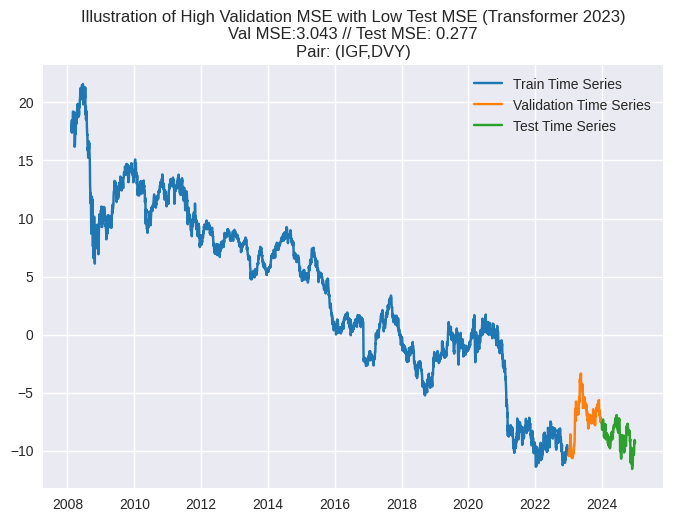

In [25]:
# plot 2: Empirical example of low test MSE and high validation MSE due to similarity in patterns between train and test timeseries
# ('24. (IGSB,SHV)', 0.00529, 41.36759, 5.6713, '-0.29% +- 0.04%', '0.06%', 0.9965) in 2024 for Transformer
ticker_a, ticker_b = "IGF","DVY"
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
burn_in = 30

pairs_timeseries_df_burned_in = pairs_timeseries_df.iloc[burn_in:].copy()


total_len = len(pairs_timeseries_df_burned_in)
train_size = int(total_len * train_frac)
dev_size   = int(total_len * dev_frac)
test_size  = total_len - train_size - dev_size # not used, but for clarity

train = pairs_timeseries_df_burned_in.iloc[:train_size]
dev   = pairs_timeseries_df_burned_in.iloc[train_size:train_size + dev_size]
test  = pairs_timeseries_df_burned_in.iloc[train_size + dev_size:]

train_color = 'tab:blue'
dev_color = 'tab:orange'
test_color = 'tab:green'

plt.plot(train['Spread_Close'], color=train_color, label="Train Time Series")
plt.plot(dev['Spread_Close'], color=dev_color, label="Validation Time Series")
plt.plot(test['Spread_Close'], color=test_color, label="Test Time Series")
plt.legend()
plt.title("Illustration of High Validation MSE with Low Test MSE (Transformer 2023)\nVal MSE:3.043 // Test MSE: 0.277\nPair: (IGF,DVY)")

In [ ]:
# plot 4 (other notebook, need timeseries): Progression of equity for randomly chosen pair of etfs (tickera, tickerb)overtimeperiodof (2008 − 2024)
# plot 2: Empirical example of low test MSE and high validation MSE due to similarity in patterns between train and test timeseries
# ('24. (IGSB,SHV)', 0.00529, 41.36759, 5.6713, '-0.29% +- 0.04%', '0.06%', 0.9965) in 2024 for Transformer
ticker_a, ticker_b = "IGF","DVY"
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
burn_in = 30

pairs_timeseries_df_burned_in = pairs_timeseries_df.iloc[burn_in:].copy()


total_len = len(pairs_timeseries_df_burned_in)
train_size = int(total_len * train_frac)
dev_size   = int(total_len * dev_frac)
test_size  = total_len - train_size - dev_size # not used, but for clarity

train = pairs_timeseries_df_burned_in.iloc[:train_size]
dev   = pairs_timeseries_df_burned_in.iloc[train_size:train_size + dev_size]
test  = pairs_timeseries_df_burned_in.iloc[train_size + dev_size:]

train_color = 'tab:blue'
dev_color = 'tab:orange'
test_color = 'tab:green'

plt.plot(train['Spread_Close'], color=train_color, label="Train Time Series")
plt.plot(dev['Spread_Close'], color=dev_color, label="Validation Time Series")
plt.plot(test['Spread_Close'], color=test_color, label="Test Time Series")
plt.legend()
plt.title("Illustration of High Validation MSE with Low Test MSE (Transformer 2023)\nVal MSE:3.043 // Test MSE: 0.277\nPair: (IGF,DVY)")